In [9]:
import sys

sys.path.append("..")
from cge_modeling import CGEModel, Variable, Parameter, Equation
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sympy as sp

In [11]:
df = pd.read_csv("../data/lesson_4_sam.csv", index_col=[0, 1], header=[0, 1]).map(float).fillna(0)
assert np.allclose(df.sum(axis=0), df.sum(axis=1))
df

Factor         Institution                  \
                                   Labor Capital   Household   Firms    Govt   
Factor      Labor                    0.0     0.0         0.0     0.0     0.0   
            Capital                  0.0     0.0         0.0     0.0     0.0   
Institution Household             7200.0     0.0         0.0  2800.0     0.0   
            Firms                    0.0  2800.0         0.0     0.0     0.0   
            Govt                     0.0     0.0      3000.0     0.0     0.0   
Production  Agriculture              0.0     0.0      1700.0     0.0   400.0   
            Industry                 0.0     0.0      1200.0     0.0  1500.0   
            Services                 0.0     0.0      3400.0     0.0  2300.0   
Activities  Agriculture              0.0     0.0         0.0     0.0     0.0   
            Industry                 0.0     0.0         0.0     0.0     0.0   
            Services                 0.0     0.0         0.0     0.0     0.0   
Other       Capital Accumulation     0.0     0.0       700.0     0.0   250.0   

                                  Production                    Activities  \
                                 Agriculture Industry Services Agriculture   
Factor      Labor                        0.0      0.0      0.0      1300.0   
            Capital                      0.0      0.0      0.0       200.0   
Institution Household                    0.0      0.0      0.0         0.0   
            Firms                        0.0      0.0      0.0         0.0   
            Govt                       150.0   1020.0    280.0         0.0   
Production  Agriculture                  0.0      0.0      0.0      1000.0   
            Industry                     0.0      0.0      0.0      2010.0   
            Services                     0.0      0.0      0.0       490.0   
Activities  Agriculture               5000.0      0.0      0.0         0.0   
            Industry                     0.0  11000.0      0.0         0.0   
            Services                     0.0      0.0   9500.0         0.0   
Other       Capital Accumulation         0.0      0.0      0.0         0.0   

                                                                  Other  
                                 Industry Services Capital Accumulation  
Factor      Labor                  1900.0   4000.0                  0.0  
            Capital                2100.0    500.0                  0.0  
Institution Household                 0.0      0.0                  0.0  
            Firms                     0.0      0.0                  0.0  
            Govt                      0.0      0.0                  0.0  
Production  Agriculture            1000.0   1000.0                 50.0  
            Industry               3510.0   3000.0                800.0  
            Services               2490.0   1000.0                100.0  
Activities  Agriculture               0.0      0.0                  0.0  
            Industry                  0.0      0.0                  0.0  
            Services                  0.0      0.0                  0.0  
Other       Capital Accumulation      0.0      0.0                  0.0

In [2]:
variable_info = [
    # Firm variables (7)
    Variable(name="Y", dims="i", description="Final output in the <dim:i> sector"),
    Variable(name="VA", dims="i", description="Value-added component of <dim:i> sector production"),
    Variable(name="VC", dims="i", description="Value-chain component of <dim:i> sector production"),
    Variable(
        name="X",
        dims=("i", "j"),
        description="Demand for <dim:i> sector goods by the <dim:j> sector as value-chain inputs",
    ),
    Variable(
        name="L_d",
        dims="i",
        extend_subscript=True,
        description="Labor demand in the <dim:i> sector",
    ),
    Variable(
        name="K_d",
        dims="i",
        extend_subscript=True,
        description="Capital demand in the <dim:i> sector",
    ),
    Variable(
        name="I_d",
        dims="i",
        extend_subscript=True,
        description="Investment capital demanded by the <dim:i> sector",
    ),
    # Prices (7)
    Variable(name="P", dims="i", description="Final good price in the <dim:i> sector, after taxes"),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the value-add component in the <dim:i> sector",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the value-chain component in the <dim:i> sector",
    ),
    Variable(
        name="P_Y",
        dims="i",
        extend_subscript=True,
        description="Final good price in the <dim:i> sector, before taxes",
    ),
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    # Household Variables (6)
    Variable(name="U", description="Household utility"),
    Variable(name="C", dims="i", description="Household consumption of <dim:i> goods"),
    Variable(
        name="I_s", extend_subscript=True, description="Investment capital supplied by households"
    ),
    Variable(name="S", description="Household savings"),
    Variable(name="income", latex_name="Omega", description="Household income, before taxes"),
    Variable(
        name="net_income", latex_name="\hat{\Omega}", description="Household income, after taxes"
    ),
    # Government variables (3)
    Variable(name="G", description="Government budget"),
    Variable(
        name="C_G",
        dims="i",
        extend_subscript=True,
        description="Government consumption of <dim:i> goods",
    ),
    Variable(
        name="S_G",
        extend_subscript=True,
        positive=None,
        description="Investment capital supplied by government",
    ),
    # Misc (1)
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
]


param_info = [
    # Production Parameters
    Parameter(
        "alpha",
        dims="i",
        description="Share of capital in production of the <dim:i> sector value-add bundle",
    ),
    Parameter(
        "alpha_k",
        dims="i",
        extend_subscript=True,
        description="Share of capital investment demanded by the <dim:i> sector",
    ),
    Parameter("A", dims="i", description="Total factor productivity of the <dim:i> sector"),
    Parameter(
        "psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of value-add bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of value chain bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of <dim:j> sector final goods in the <dim:i> value chain bundle",
    ),
    # Tax parameters
    Parameter("tau", dims="i", description="Sales tax rate on final goods in the <dim:i> sector"),
    Parameter("tau_income", latex_name=r"\tau_{\Omega}", description="Income tax rate"),
    # Household parameters
    Parameter(
        "gamma",
        dims="i",
        description="Household elasticity of consumption utility for <dim:i> sector goods",
    ),
    Parameter("mps", latex_name="phi", description="Household marginal propensity to save"),
    # Government parameters
    Parameter(
        "alpha_G",
        dims="i",
        description="Share of <dim:i> sector final goods in governmnet consumption",
    ),
    # Exogenous values
    Parameter("L_s", description="Exogenous labor supply"),
    Parameter("K_s", description="Exogenous capital supply"),
    Parameter("P_Ag_bar", latex_name=r"\bar{P}_{Ag}", description="Numeraire price"),
    Parameter(
        "S_G_bar",
        latex_name=r"\bar{S}_G",
        description="Exogenous level of governmnet savings",
        positive=None,
    ),
]

equations = [
    # Frim Block
    Equation("Final good production of sector <dim:i>", "P_Y * Y = P_VC * VC + P_VA * VA"),
    Equation("Sector <dim:i> demand for value chain bundle", "VC = psi_VC * Y"),
    Equation("Sector <dim:i> demand for value-add bundle", "VA = psi_VA * Y"),
    Equation("Sector <dim:i> production of labor-capital", "VA = A * K_d^alpha * L_d^(1-alpha)"),
    Equation("Sector <dim:i> demand for capital", "K_d = alpha * VA * P_VA / r"),
    Equation("Sector <dim:i> demand for labor", "L_d = (1 - alpha) * VA * P_VA / w"),
    Equation(
        "Sector <dim:i> production of value chain bundle",
        "VC * P_VC = Sum(P.subs({i:j}) * X.subs([(i,k), (j,i), (k,j)]), (j, 0, 2))",
    ),
    Equation("Demand for <dim:i> sector goods by <dim:j>", "X = psi_X * VC.subs({i:j})"),
    Equation("<dim:i> sector demand for investment capital", "P * I_d = alpha_k * I_s"),
    # Government block
    Equation(
        "Government budget constraint",
        "G + S_G = tau_income * income + Sum(tau * P_Y * Y, (i, 0, 2))",
    ),
    Equation("Government consumption of <dim:i> sector goods", "P * C_G = alpha_G * G"),
    Equation("Sector <dim:i> after-tax price", "P = (1 + tau) * P_Y"),
    Equation("Exogenous government savings", "S_G = S_G_bar"),
    # Household block
    Equation("Household pre-tax income", "income = w * L_s + r * K_s"),
    Equation("Household after-tax income", "net_income = (1 - tau_income) * income"),
    Equation("Household utility", "U = Product(C**gamma, (i, 0, 2))"),
    Equation("Household demand for good <dim:i>", "C * P = gamma * (1 - mps) * net_income"),
    Equation("Household savings", "S = mps * net_income"),
    # Economic equilibrium
    Equation("Investment market clearing", "I_s = S + S_G + resid"),
    Equation("Labor market clearing", "L_s = Sum(L_d, (i, 0, 2))"),
    Equation("Capital market clearing", "K_s = Sum(K_d, (i, 0, 2))"),
    Equation("<dim:i> sector goods market clearing", "Y = C + Sum(X, (j, 0, 2)) + C_G + I_d"),
    Equation("Numeraire", 'P.subs({i:"Ag"}) = P_Ag_bar'),
]

assert len(variable_info) == len(
    equations
), f"Found {len(variable_info)} variables but {len(equations)} equations"

In [3]:
sectors = ["Ag", "Ind", "Serv"]
coords = {"i": sectors, "j": sectors}

mod = CGEModel(variables=variable_info, parameters=param_info, equations=equations, coords=coords)

In [4]:
mod.equation_table()

<IPython.core.display.Latex object>

In [5]:
# Normalize prices
initial_values = {"w": 1, "r": 1, "e": 1, "resid": 0}
initial_values.update({f"P_VA_{s}": 1 for s in sectors})
initial_values.update({f"P_VC_{s}": 1 for s in sectors})
initial_values.update({f"P_{s}": 1 for s in sectors})

len(initial_values)

13

In [6]:
len(mod.unpacked_parameter_names) + 13

52

In [7]:
len(mod.unpacked_equations)

55

In [12]:
short_to_long = {"Ag": "Agriculture", "Ind": "Industry", "Serv": "Services"}

# Normalize prices
initial_values = {"w": 1, "r": 1, "e": 1, "resid": 0}
initial_values.update({f"P_VA_{s}": 1 for s in sectors})
initial_values.update({f"P_VC_{s}": 1 for s in sectors})
initial_values.update({f"P_{s}": 1 for s in sectors})

# Enter data from SAM
initial_values["income_tax"] = df.loc[("Institution", "Govt"), ("Institution", "Household")]
initial_values["S"] = df.loc[("Other", "Capital Accumulation"), ("Institution", "Household")]
initial_values["S_G"] = df.loc[("Other", "Capital Accumulation"), ("Institution", "Govt")]

# Aggregates
initial_values["L_s"] = df.loc[("Institution", "Household"), ("Factor", "Labor")]
initial_values["K_s"] = df.loc[("Institution", "Firms"), ("Factor", "Capital")]

initial_values["income"] = (
    initial_values["w"] * initial_values["L_s"] + initial_values["r"] * initial_values["K_s"]
)
initial_values["tau_income"] = initial_values["income_tax"] / initial_values["income"]
initial_values["net_income"] = (1 - initial_values["tau_income"]) * initial_values["income"]

for sector in sectors:
    long_sector = short_to_long[sector]
    initial_values[f"L_d_{sector}"] = (
        df.loc[("Factor", "Labor"), ("Activities", long_sector)] / initial_values["w"]
    )
    initial_values[f"K_d_{sector}"] = (
        df.loc[("Factor", "Capital"), ("Activities", long_sector)] / initial_values["r"]
    )
    initial_values[f"C_G_{sector}"] = df.loc[("Production", long_sector), ("Institution", "Govt")]

    initial_values[f"sales_tax_{sector}"] = df.loc[
        ("Institution", "Govt"), ("Production", long_sector)
    ]
    initial_values[f"C_{sector}"] = df.loc[
        ("Production", long_sector), ("Institution", "Household")
    ]

    # Excess demand -- What is this in terms of imports/exports?
    initial_values[f"I_d_{sector}"] = df.loc[
        ("Production", long_sector), ("Other", "Capital Accumulation")
    ]

    initial_values[f"Y_{sector}"] = df.sum(axis=0).loc[("Production", long_sector)]

    # Work out the tax rate from tax reciepts

    T_sec = initial_values[f"sales_tax_{sector}"]
    Y_sec = initial_values[f"Y_{sector}"]
    P_sec = initial_values[f"P_{sector}"]

    initial_values[f"tau_{sector}"] = T_sec / (Y_sec - T_sec)
    initial_values[f"P_Y_{sector}"] = P_sec / (1 + initial_values[f"tau_{sector}"])

# Adjust values in SAM to account for non-normalized prices
for sector in sectors:
    long_sector = short_to_long[sector]
    for sector_j in sectors:
        long_sector_j = short_to_long[sector_j]
        SAM_idx = ("Production", long_sector), ("Activities", long_sector_j)
        initial_values[f"X_{sector}_{sector_j}"] = df.loc[SAM_idx]

inital_values_temp = initial_values.copy()
for key in initial_values:
    if key not in mod.unpacked_parameter_names + mod.unpacked_variable_names:
        del inital_values_temp[key]
initial_values = inital_values_temp

In [13]:
init_res = mod.calibrate(initial_values)
init_res.success

True

In [15]:
init_res.to_frame()

,initial,fitted
Y_Ag,5150.0,5150.000000
Y_Ind,12020.0,12020.000000
Y_Serv,9780.0,9780.000000
VA_Ag,NaN,1500.000000
VA_Ind,NaN,4000.000000
...,...,...
alpha_G_Serv,NaN,0.547619
L_s,7200.0,7200.000000
K_s,2800.0,2800.000000
P_Ag_bar,NaN,1.000000


In [24]:
init_res.to_frame()["fitted"]["alpha_Ag"]

0.13333333333333333

In [11]:
tax_cut = mod.simulate(
    init_res,
    final_delta_pct={f"tau_{s}": 0.9 for s in sectors},
    name="10% Tax Cut",
    n_iter_euler=10_000,
    method="trust-krylov",
)

In [10]:
tax_cut.success

True

In [18]:
price_vars = (
    tax_cut.to_frame()
    .loc[lambda x: x.index.str.startswith("P") | x.index.isin(["r", "w"])]
    .index.tolist()
)
tax_vars = [f"tau_{s}" for s in sectors]

<Axes: >

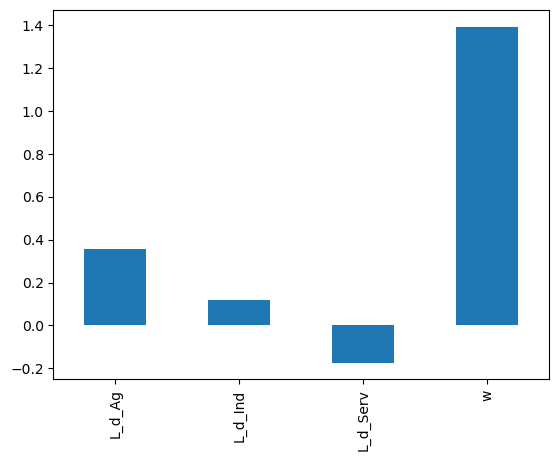

In [30]:
tax_cut.to_frame().pct_change(axis=1)["fitted"].loc[["L_d_Ag", "L_d_Ind", "L_d_Serv", "w"]].mul(
    100
).plot.bar()